## Import Libraries


In [ ]:
# !pip install pyspark

In [ ]:
# from pyspark import SparkContext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_regression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from matplotlib.cm import coolwarm


## Load data

In [ ]:
df = pd.read_csv('/content/games.csv')
df['season'] = df['season'].astype(int)
df['home_club_id'] = df['home_club_id'].astype(int)

print(len(df))

59288


## Filtering Data

In [ ]:
df=df[df['competition_id'].isin(['L1', 'NL1', 'ES1', 'PO1', 'FR1', 'GB1', 'IT1', 'TR1'])]
print(len(df))

28449


## Data Preparation

In [ ]:

home_club_goals = df.groupby(['home_club_id', 'season', 'competition_id']).agg(
    Total_Home_Club_Goals=('home_club_goals', 'sum'),
    Total_Away_Club_Goals=('away_club_goals', 'sum')
).reset_index()

away_club_goals = df.groupby(['away_club_id', 'season', 'competition_id']).agg(
    Total_Home_Club_Goals=('home_club_goals', 'sum'),
    Total_Away_Club_Goals=('away_club_goals', 'sum')
).reset_index()


merged_goals = pd.merge(home_club_goals, away_club_goals, left_on=['home_club_id', 'competition_id', 'season'], right_on=['away_club_id', 'competition_id', 'season'], how='outer').fillna(0)
merged_goals['club_id'] = merged_goals['home_club_id'].combine_first(merged_goals['away_club_id'])
merged_goals.drop(['home_club_id', 'away_club_id'], axis=1, inplace=True)

total_home_goals = merged_goals.groupby(['club_id','season', 'competition_id']).agg({'Total_Home_Club_Goals_x': 'sum', 'Total_Away_Club_Goals_y': 'sum'}).reset_index()
total_away_goals = merged_goals.groupby(['club_id','season', 'competition_id']).agg({'Total_Home_Club_Goals_y': 'sum', 'Total_Away_Club_Goals_x': 'sum'}).reset_index()


total_home_goals['GS'] = total_home_goals['Total_Home_Club_Goals_x'] + total_home_goals['Total_Away_Club_Goals_y']
total_home_goals.drop(['Total_Home_Club_Goals_x', 'Total_Away_Club_Goals_y'], axis=1, inplace=True)

total_away_goals['GC'] = total_away_goals['Total_Home_Club_Goals_y'] + total_away_goals['Total_Away_Club_Goals_x']
total_away_goals.drop(['Total_Home_Club_Goals_y', 'Total_Away_Club_Goals_x'], axis=1, inplace=True)

total_goals_info = pd.merge(total_home_goals , total_away_goals, on = ['club_id', 'competition_id', 'season'])
total_goals_info['club_id'] = total_goals_info['club_id'].astype(int)
total_goals_info['GC'] = total_goals_info['GC'].astype(int)
total_goals_info['GS'] = total_goals_info['GS'].astype(int)
total_goals_info['GD'] = total_goals_info['GS'] - total_goals_info['GC']

goals_for_home = df.groupby(['home_club_id', 'competition_id', 'season'])['home_club_goals'].agg(list).reset_index()
goals_against_home = df.groupby(['home_club_id', 'competition_id', 'season'])['away_club_goals'].agg(list).reset_index()

goals_against_away = df.groupby(['away_club_id', 'competition_id', 'season'])['home_club_goals'].agg(list).reset_index()
goals_for_away = df.groupby(['away_club_id', 'competition_id', 'season'])['away_club_goals'].agg(list).reset_index()

In [ ]:
home_matches = pd.merge(goals_for_home, goals_against_home, left_on=['home_club_id', 'competition_id', 'season'], right_on=['home_club_id', 'competition_id', 'season'], how='outer').fillna(0)
away_matches = pd.merge(goals_against_away, goals_for_away, left_on=['away_club_id', 'competition_id', 'season'], right_on=['away_club_id', 'competition_id', 'season'], how='outer').fillna(0)

home_matches_key_value = [
    ((row['home_club_id'], row['competition_id'], row['season']),
     [row['home_club_goals'], row['away_club_goals']])
    for index, row in home_matches.iterrows()
]
away_matches_key_value = [
    ((row['away_club_id'], row['competition_id'], row['season']),
     [row['away_club_goals'], row['home_club_goals']])
    for index, row in away_matches.iterrows()
]

def process_data(data_list):
    results_dict = {}
    for data in data_list:
        try:
            key, value = data
            club_id, competition_id, season = key
            home_club_goals, away_club_goals = value
            # Mapper
            results = []
            for x, y in zip(home_club_goals, away_club_goals):
                results.append(x - y)
            total_matches = len(results)
            wins = sum(1 for result in results if result > 0)
            losses = sum(1 for result in results if result < 0)
            draws = sum(1 for result in results if result == 0)

            result_key = (club_id, competition_id, season)

            # Reducer on Home or Away level
            if result_key in results_dict:
                existing_total, existing_wins, existing_losses, existing_draws = results_dict[result_key]
                results_dict[result_key] = (
                    existing_total + total_matches,
                    existing_wins + wins,
                    existing_losses + losses,
                    existing_draws + draws
                )
            else:
                results_dict[result_key] = (total_matches, wins, losses, draws)
        except ValueError as e:
            print(f"Error with data: {data}")
            raise e
    return results_dict

def combine_results(dict_a, dict_b):
    for key, values in dict_b.items():
        if key in dict_a:
            existing_total, existing_wins, existing_losses, existing_draws = dict_a[key]
            total_matches, wins, losses, draws = values
            dict_a[key] = (
                existing_total + total_matches,
                existing_wins + wins,
                existing_losses + losses,
                existing_draws + draws
            )
        else:
            dict_a[key] = values
    return dict_a

# Process home and away data separately
results_home = process_data(home_matches_key_value)
results_away = process_data(away_matches_key_value)

# Combine home and away results
team_win_lose = combine_results(results_home, results_away)

print(team_win_lose)


{(3, 'L1', 2014): (34, 9, 12, 13), (3, 'L1', 2015): (34, 10, 11, 13), (3, 'L1', 2016): (34, 12, 9, 13), (3, 'L1', 2017): (34, 5, 22, 7), (3, 'L1', 2019): (34, 10, 18, 6), (3, 'L1', 2020): (34, 8, 17, 9), (3, 'L1', 2021): (34, 14, 10, 10), (3, 'L1', 2022): (15, 4, 6, 5), (4, 'L1', 2012): (34, 11, 12, 11), (4, 'L1', 2013): (34, 5, 18, 11), (4, 'L1', 2018): (34, 3, 21, 10), (5, 'IT1', 2012): (38, 21, 8, 9), (5, 'IT1', 2013): (38, 16, 13, 9), (5, 'IT1', 2014): (38, 13, 12, 13), (5, 'IT1', 2015): (38, 15, 11, 12), (5, 'IT1', 2016): (38, 18, 11, 9), (5, 'IT1', 2017): (38, 18, 10, 10), (5, 'IT1', 2018): (38, 19, 8, 11), (5, 'IT1', 2019): (37, 18, 10, 9), (5, 'IT1', 2020): (39, 25, 7, 7), (5, 'IT1', 2021): (38, 26, 4, 8), (5, 'IT1', 2022): (15, 10, 2, 3), (6, 'TR1', 2016): (34, 6, 21, 7), (10, 'L1', 2020): (34, 9, 17, 8), (10, 'L1', 2021): (34, 5, 16, 13), (11, 'GB1', 2012): (38, 21, 7, 10), (11, 'GB1', 2013): (38, 24, 7, 7), (11, 'GB1', 2014): (38, 22, 7, 9), (11, 'GB1', 2015): (38, 20, 7, 11

## Final club information

In [ ]:
club_id = []
season =  []
competition_id = []
matches_played = []
wins = []
draws = []
losses = []

for key, value in team_win_lose.items():
    club_id.append(key[0])
    competition_id.append(key[1])
    season.append(key[2])
    matches_played.append(value[0])
    wins.append(value[1])
    losses.append(value[2])
    draws.append(value[3])

new_df = pd.DataFrame({
    'club_id': club_id,
    'season': season,
    'competition_id': competition_id,
    'matches_played': matches_played,
    'wins': wins,
    'draws': draws,
    'losses': losses
})
final_club_information = pd.merge(total_goals_info, new_df, on = ['club_id','season', 'competition_id'])

## Adding label

In [ ]:
## Each element is array is a tuple (club_id , season)
champions = {
    "L1": [(27, 2012), (27, 2013), (27, 2014), (27, 2015), (27, 2016), (27, 2017), (27, 2018), (27, 2019), (27, 2020), (27, 2021)],
    "NL1": [(610, 2012), (610, 2013), (383, 2014), (383, 2015), (234, 2016), (383, 2017), (610, 2018), (610, 2019), (610, 2020), (610, 2021)],
    "ES1": [(714, 2012), (13, 2013), (714, 2014), (714, 2015), (418, 2016), (714, 2017), (714, 2018), (418, 2019), (13, 2020), (418, 2021)],
    "PO1": [(720, 2012), (294, 2013), (294, 2014), (294, 2015), (294, 2016), (720, 2017), (294, 2018), (720, 2019), (336, 2020), (720, 2021)],
    "FR1": [(583, 2012), (583, 2013), (583, 2014), (583, 2015), (162, 2016), (583, 2017), (583, 2018), (583, 2019), (1082, 2020), (583, 2021)],
    "GB1": [(985, 2012), (281, 2013), (631, 2014), (1003, 2015), (631, 2016), (281, 2017), (281, 2018), (31, 2019), (281, 2020), (281, 2021)],
    "IT1": [(506, 2012), (506, 2013), (506, 2014), (506, 2015), (506, 2016), (506, 2017), (506, 2018), (506, 2019), (46, 2020), (5, 2021)],
    "TR1": [(141, 2012), (36, 2013), (141, 2014), (114, 2015), (114, 2016), (141, 2017), (141, 2018), (6890, 2019), (114, 2020), (449, 2021)]
}
def is_champion(row):
    competition = row['competition_id']
    club_id = row['club_id']
    season = row['season']
    # Check if the competition is in the dictionary and if the (club_id, season) tuple is in the list for that competition
    if competition in champions and (club_id, season) in champions[competition]:
        return 1
    else:
        return 0

# Apply the function to each row
final_club_information['champion'] = final_club_information.apply(is_champion, axis=1)

print(final_club_information)

      club_id  season competition_id  GS  GC  GD  matches_played  wins  draws  \
0           3    2014             L1  34  40  -6              34     9     13   
1           3    2015             L1  38  42  -4              34    10     13   
2           3    2016             L1  51  42   9              34    12     13   
3           3    2017             L1  35  70 -35              34     5      7   
4           3    2019             L1  51  69 -18              34    10      6   
...       ...     ...            ...  ..  ..  ..             ...   ...    ...   
1672    68608    2013            PO1  19  33 -14              30     6     10   
1673    68608    2014            PO1  34  35  -1              34    12     12   
1674    68608    2015            PO1  44  66 -22              34    10     11   
1675    68608    2016            PO1  27  45 -18              34     9      9   
1676    68608    2017            PO1  33  46 -13              34     9     10   

      losses  champion  
0 

## Add Feature Engineering

In [ ]:
def Extract_Feature_Engineering(final_club_information):
    final_club_information['win_match_ratio'] = (final_club_information['wins'] + 1)/ final_club_information['matches_played']

    final_club_information['gs_match_ratio'] = (final_club_information['GS'] + 1)/ final_club_information['matches_played']

    final_club_information['gc_match_ratio'] = (final_club_information['GC'] + 1)/ final_club_information['matches_played']

    final_club_information['win_gs_ratio'] = (final_club_information['wins'] + 1)/(final_club_information['GS'] + 1)

    final_club_information['win_lost_ratio'] = (final_club_information['wins'] + 1)/(final_club_information['losses'] + 1)

    final_club_information['gs_gc'] = (final_club_information['GD']) + 0.1

    final_club_information['wins_draws_ratio'] = (final_club_information['wins'] +  1) / (final_club_information['draws'] + 1)

    final_club_information['gs_gd'] = (final_club_information['GS'] + 1) + (final_club_information['GD'])



Extract_Feature_Engineering(final_club_information)
print(final_club_information)


      club_id  season competition_id  GS  GC  GD  matches_played  wins  draws  \
0           3    2014             L1  34  40  -6              34     9     13   
1           3    2015             L1  38  42  -4              34    10     13   
2           3    2016             L1  51  42   9              34    12     13   
3           3    2017             L1  35  70 -35              34     5      7   
4           3    2019             L1  51  69 -18              34    10      6   
...       ...     ...            ...  ..  ..  ..             ...   ...    ...   
1672    68608    2013            PO1  19  33 -14              30     6     10   
1673    68608    2014            PO1  34  35  -1              34    12     12   
1674    68608    2015            PO1  44  66 -22              34    10     11   
1675    68608    2016            PO1  27  45 -18              34     9      9   
1676    68608    2017            PO1  33  46 -13              34     9     10   

      losses  champion  win

## Remove unwanted features


In [ ]:
x = final_club_information.drop(['season', 'competition_id','club_id','champion'], axis = 1, inplace = False)
y = final_club_information['champion']

## MI_SCORE


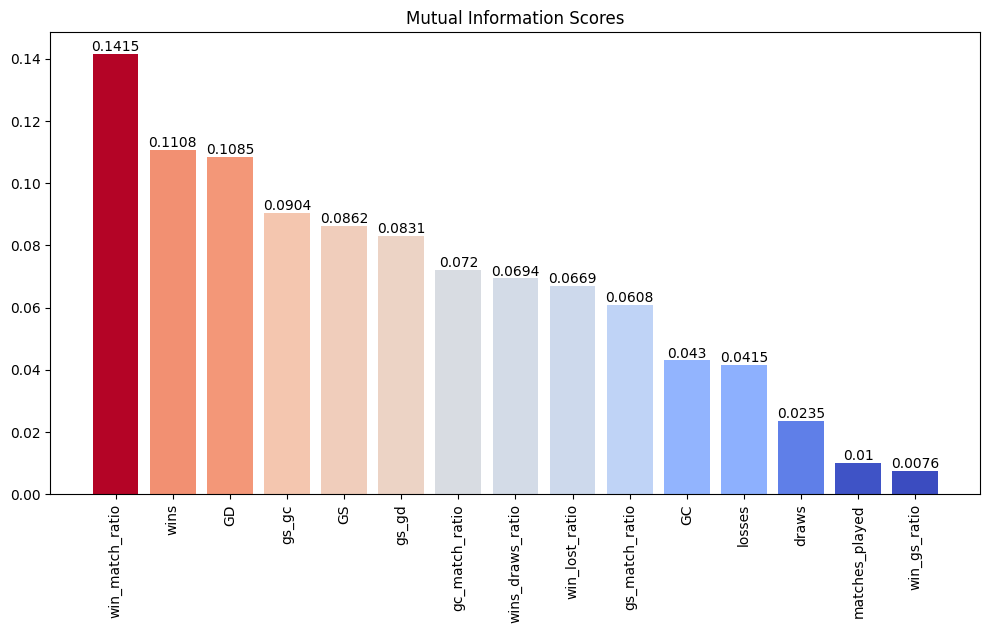

In [ ]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=False)
    height = np.arange(len(scores))
    ticks = list(scores.index)

    plt.figure(figsize=(12, 6))
    norm = plt.Normalize(scores.min(), scores.max())
    colors = coolwarm(norm(scores.values))

    plt.bar(height, scores, color=colors)
    plt.xticks(height, ticks, rotation=90)
    plt.title("Mutual Information Scores")

    for index, value in enumerate(scores):
        plt.text(index, value, str(round(value, 4)), ha='center', va='bottom')

    plt.show()

mi_score=make_mi_scores(x,y)
plot_mi_scores(mi_score)

[link text](https://)## Smote For Balancing Data

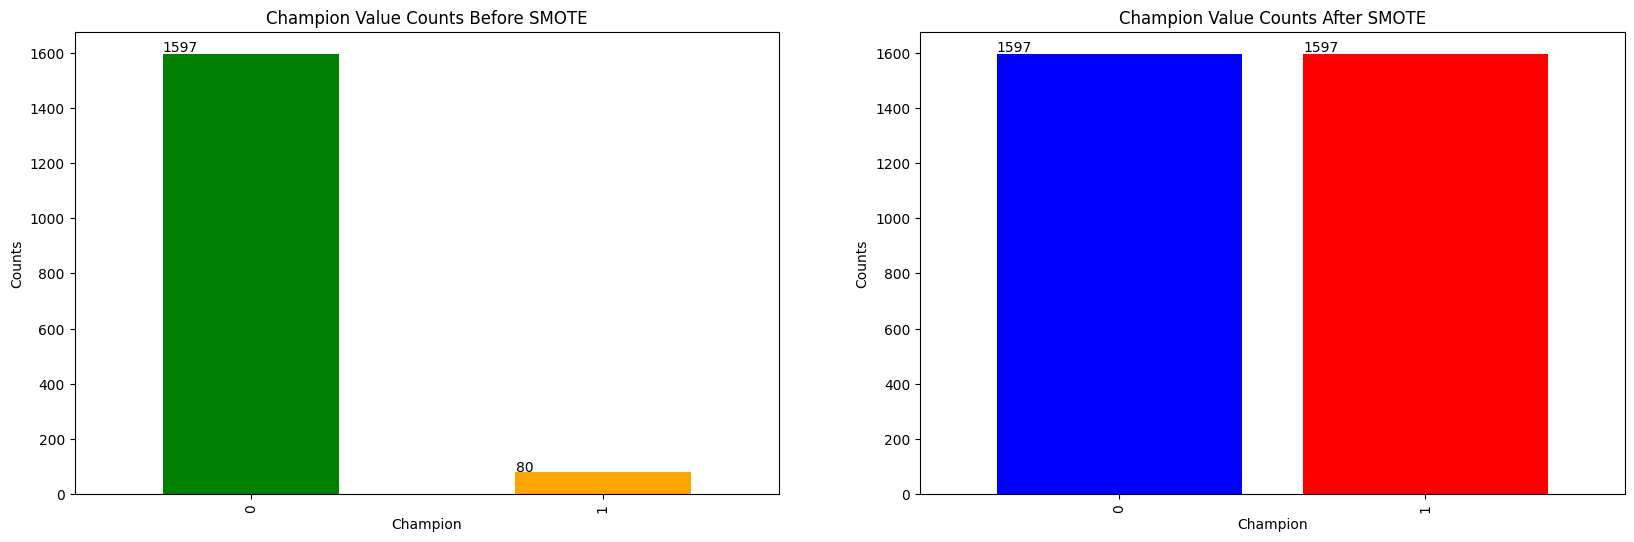

In [ ]:
plt.figure(figsize=(20, 6))

# Subplot 1: Before SMOTE
plt.subplot(1, 2, 1)
ax_before = y.value_counts().plot(kind='bar', color=['green', 'orange'])
ax_before.set_title("Champion Value Counts Before SMOTE")
ax_before.set_xlabel("Champion")
ax_before.set_ylabel("Counts")
for p in ax_before.patches:
    ax_before.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Applying SMOTE
smote = SMOTE()
x_sm, y_sm = smote.fit_resample(x, y)
value_counts = pd.DataFrame(y_sm, columns=['champion']).champion.value_counts()

# Subplot 2: After SMOTE
plt.subplot(1, 2, 2)
ax_after = value_counts.plot(kind='bar', color=['blue', 'red'], width=0.8)
ax_after.set_title("Champion Value Counts After SMOTE")
ax_after.set_xlabel("Champion")
ax_after.set_ylabel("Counts")
for p in ax_after.patches:
    ax_after.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.show()

## splitting into train and test set Percentage 75% to 25%


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_sm, y_sm,random_state = 42)

## Classification_Report

In [ ]:
def report(classifier, x_test=x_test, y_test=y_test):
    print("Classification Report: \n")
    y_preds = classifier.predict(x_test)
    print(classification_report(y_test, y_preds))

    print("Confusion Matrix: \n")
    # Calculate confusion matrix and then use ConfusionMatrixDisplay
    cm = confusion_matrix(y_test, y_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    print("ROC: \n")
    # Calculate ROC curve and then use RocCurveDisplay
    fpr, tpr, _ = roc_curve(y_test, classifier.predict_proba(x_test)[:, 1])
    roc_disp = RocCurveDisplay(fpr=fpr, tpr=tpr)
    roc_disp.plot()
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.show()


## Modeling

## Logistic_Regression

In [ ]:
log_clf = LogisticRegression(C=5.428675439323859,
                             penalty='l1',
                             solver='liblinear',
                             random_state=41)

param_grid = {
    'max_iter': [10, 50, 100, 150, 200]  # Adjust this list based on your needs and computational budget
}

grid_search = GridSearchCV(log_clf, param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Best max_iter: ", grid_search.best_params_['max_iter'])
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

Best max_iter:  150
Best cross-validation score: 0.98


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
log_clf = LogisticRegression(max_iter = 150,
                             C = 5.428675439323859,
                             penalty='l1',
                             solver='liblinear',
                             random_state = 41).fit(x_train, y_train)

cv_lr = cross_val_score(log_clf, x_train, y_train, cv = 10)
lr_score = np.mean(cv_lr)
print("LR Score: ", lr_score)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

LR Score:  0.9787116457461646


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Classification Report: 

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       410
           1       0.96      0.97      0.96       389

    accuracy                           0.96       799
   macro avg       0.96      0.96      0.96       799
weighted avg       0.96      0.96      0.96       799

Confusion Matrix: 



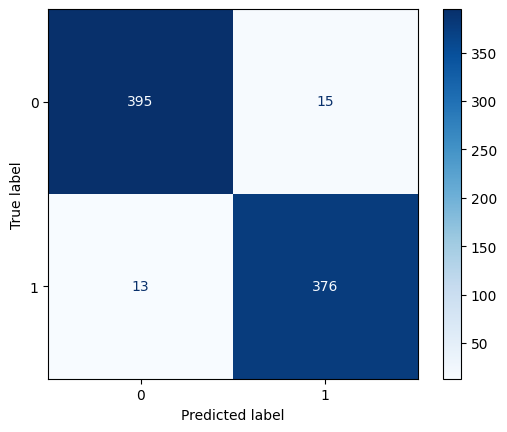

ROC: 



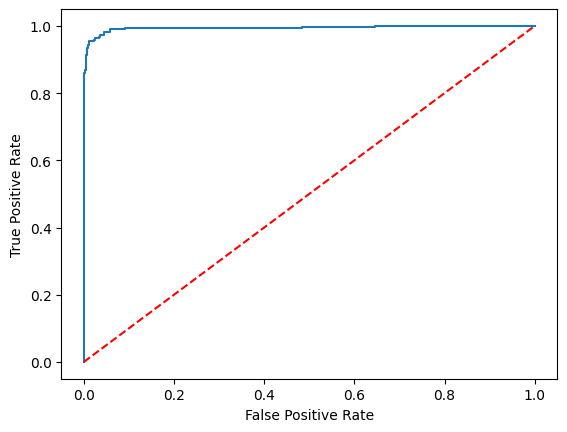

In [ ]:
report(log_clf)


##KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# parameter tuned by gridsearchcv
knn_clf = KNeighborsClassifier(algorithm='auto',
                                leaf_size=10,
                                n_neighbors=2,
                                p = 1).fit(x_train, y_train)

cv_knn = cross_val_score(knn_clf, x_train, y_train, cv = 10)
knn_score = np.mean(cv_knn)
print("KNN Score: ", knn_score)

KNN Score:  0.9628451882845189


Classification Report: 

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       410
           1       0.95      0.98      0.97       389

    accuracy                           0.97       799
   macro avg       0.97      0.97      0.97       799
weighted avg       0.97      0.97      0.97       799

Confusion Matrix: 



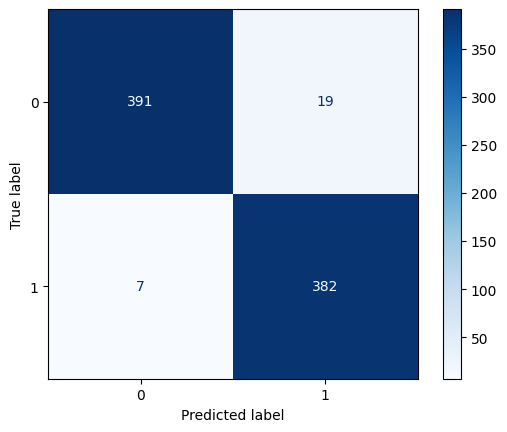

ROC: 



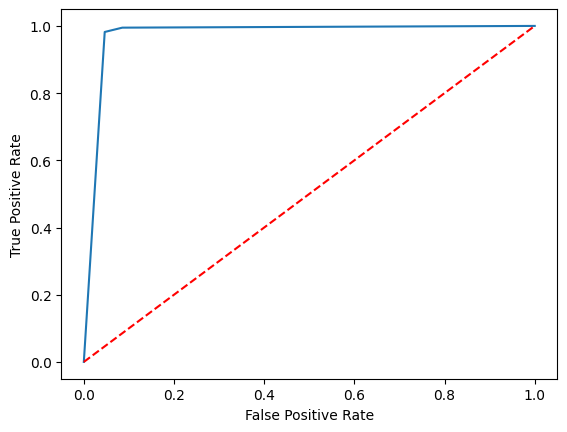

In [ ]:
report(knn_clf)

## Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# parameters were taken by randomizedsearchcv
rand_clf = RandomForestClassifier(n_estimators=1000,
                                 min_samples_split = 4,
                                 min_samples_leaf = 1,
                                 max_depth = None,
                                 random_state = 35).fit(x_train, y_train)

cv_rf = cross_val_score(rand_clf, x_train, y_train, cv = 10)
rf_score = np.mean(cv_rf)
print("RF Score: ", rf_score)

RF Score:  0.9770345188284519


Classification Report: 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       410
           1       0.96      0.99      0.98       389

    accuracy                           0.98       799
   macro avg       0.98      0.98      0.98       799
weighted avg       0.98      0.98      0.98       799

Confusion Matrix: 



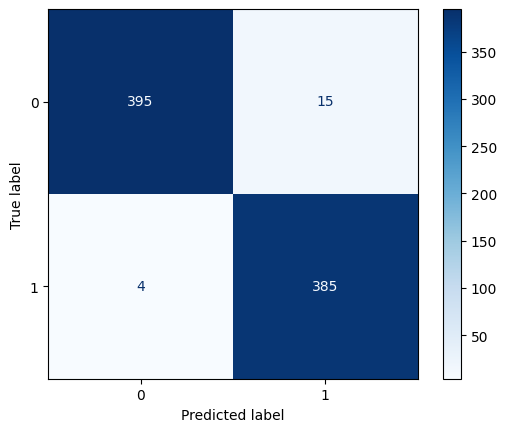

ROC: 



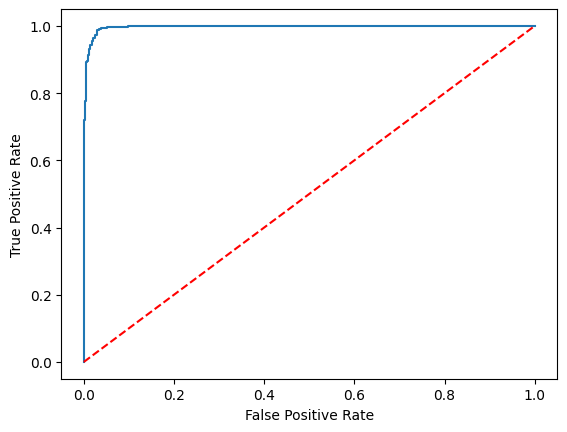

In [ ]:
report(rand_clf)

## Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_clf = GradientBoostingClassifier(learning_rate=0.1,
                                 loss='deviance',
                                 max_depth=2,
                                 min_samples_leaf=5,
                                 min_samples_split=2,
                                 n_estimators=500,
                                 random_state=31).fit(x_train, y_train)

cv_gbc = cross_val_score(gbc_clf, x_train, y_train, cv = 10)
gbc_score = np.mean(cv_gbc)
print("GBC Score: ", gbc_score)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
 

GBC Score:  0.9745432357043237


Classification Report: 

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       410
           1       0.96      0.99      0.97       389

    accuracy                           0.97       799
   macro avg       0.97      0.97      0.97       799
weighted avg       0.97      0.97      0.97       799

Confusion Matrix: 



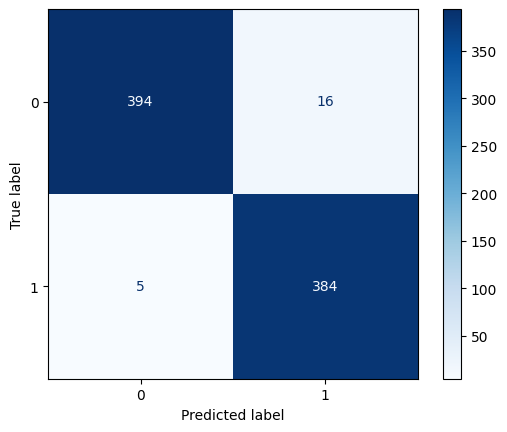

ROC: 



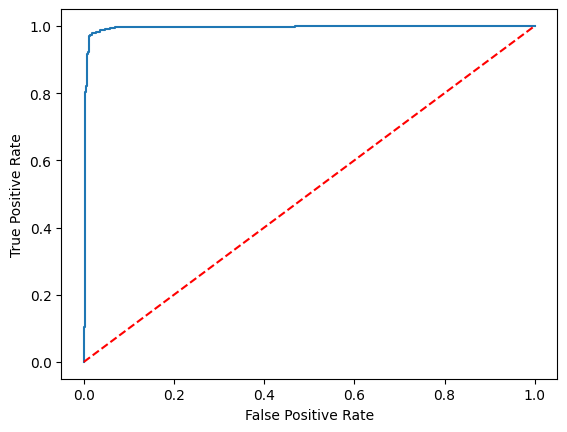

In [ ]:
report(gbc_clf)

## LightBGM

In [ ]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier().fit(x_train, y_train)
cv_lgbm = cross_val_score(lgbm, x_train, y_train, cv = 10)
lgbm_score = np.mean(cv_lgbm)
print("Lgbm Score: ", lgbm_score)

[LightGBM] [Info] Number of positive: 1208, number of negative: 1187
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2403
[LightGBM] [Info] Number of data points in the train set: 2395, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504384 -> initscore=0.017537
[LightGBM] [Info] Start training from score 0.017537
[LightGBM] [Info] Number of positive: 1087, number of negative: 1068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2391
[LightGBM] [Info] Number of data points in the train set: 2155, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504408 -> initscore=0.017634
[LightGBM] [Info] Start training from score 0.017634
[LightGBM] [Info] Numb

Classification Report: 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       410
           1       0.97      0.99      0.98       389

    accuracy                           0.98       799
   macro avg       0.98      0.98      0.98       799
weighted avg       0.98      0.98      0.98       799

Confusion Matrix: 



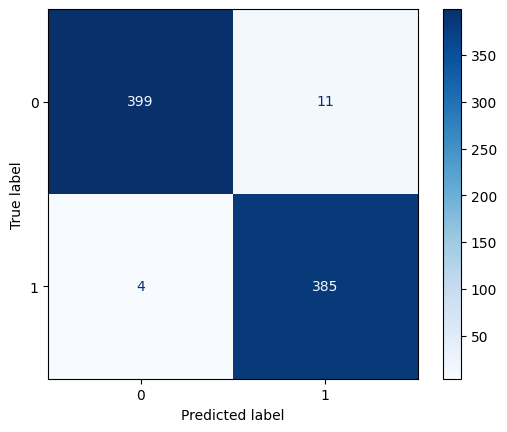

ROC: 



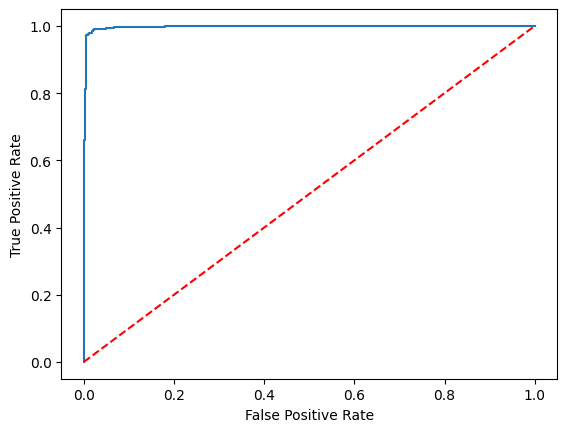

In [ ]:
report(lgbm)

## Score Analysis

In [ ]:
score_dict= {'Logistic Regression':lr_score,
             'KNN':knn_score,
             'Random Forest': rf_score,
             'Gradient Boost':gbc_score,
             'LightBGM':lgbm_score}
pd.DataFrame.from_dict(score_dict, orient = 'index', columns = ['Score'])

,Score
Logistic Regression,0.978712
KNN,0.962845
Random Forest,0.977035
Gradient Boost,0.974543
LightBGM,0.978712


## Create Single DataFrame

In [ ]:
def Create_Single_DataFrame(UserInput):
    data = {
        'club_id': [UserInput[0]],
        'season': [UserInput[1]],  # Assuming 'None' where the data is missing
        'competition_id': [UserInput[2]],
        'GS': [UserInput[3]],  # Goals Scored
        'GC': [UserInput[4]],  # Goals Conceded
        'GD': [UserInput[5]],  # Goal Difference
        'matches_played': [UserInput[6]],
        'wins': [UserInput[7]],  # Wins
        'draws': [UserInput[8]],  # Draws
        'losses': [UserInput[9]]  # Losses
    }

    # Create DataFrame
    df = pd.DataFrame(data)
    return df



## Single Prediction



In [ ]:
# 'club_id', 'season', 'competition_id', 'Goals-For', 'Goals-Against', 'Goal-Difference', 'Wins', 'Draws', 'Losses'
UserInput=[31,2023,'GB1',72,29,43,30,23,4,3]

User_Input_Df=Create_Single_DataFrame(UserInput)

Extract_Feature_Engineering(User_Input_Df)
x = User_Input_Df.drop(['season', 'competition_id','club_id'], axis = 1, inplace = False)

if log_clf.predict(x)[0] == 1 :
  print("Winner")
else:
  print("Better luck another season")


Winner


## Testing

In [ ]:
competition_id_value = 'GB1'  # Set your competition ID
season_id_value = 2012  # Set your season ID as an integer
filtered_df = final_club_information[(final_club_information['competition_id'] == competition_id_value) &
                 (final_club_information['season'] == season_id_value)]

print(filtered_df)

      club_id  season competition_id  GS  GC  GD  matches_played  wins  draws  \
25         11    2012            GB1  72  37  35              38    21     10   
123        29    2012            GB1  55  40  15              38    16     15   
134        31    2012            GB1  71  43  28              38    16     13   
333       148    2012            GB1  66  46  20              38    21      9   
375       180    2012            GB1  49  60 -11              38     9     14   
474       281    2012            GB1  66  34  32              38    23      9   
485       289    2012            GB1  41  54 -13              38     9     12   
573       379    2012            GB1  45  53  -8              38    12     10   
625       405    2012            GB1  47  69 -22              38    10     11   
749       512    2012            GB1  34  45 -11              38     9     15   
837       631    2012            GB1  75  39  36              38    22      9   
899       762    2012       

In [ ]:
competition_id_value = 'ES1'  # Set your competition ID
season_id_value = 2018  # Set your season ID as an integer

filtered_df = final_club_information[(final_club_information['competition_id'] == competition_id_value) &
                 (final_club_information['season'] == season_id_value)]
print(filtered_df)

      club_id  season competition_id  GS  GC  GD  matches_played  wins  draws  \
53         13    2018            ES1  55  29  26              38    22     10   
306       131    2018            ES1  90  36  54              38    26      9   
349       150    2018            ES1  44  52  -8              38    14      8   
551       366    2018            ES1  32  51 -19              38    10     11   
559       367    2018            ES1  41  70 -29              38     8      8   
568       368    2018            ES1  62  47  15              38    17      8   
681       418    2018            ES1  63  46  17              38    21      5   
832       621    2018            ES1  41  45  -4              38    13     14   
863       681    2018            ES1  45  46  -1              38    13     11   
875       714    2018            ES1  48  50  -2              38    14     11   
988       940    2018            ES1  53  62  -9              38    10     11   
1115     1049    2018       